In [54]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from helpers.mv_single_binary import majority_voting
import helpers.algorithms_utils as alg_utils
from helpers.truth_finder_single import truth_finder_single
from helpers.truth_finder import expectation_maximization
import multiprocessing
import time

In [37]:
'''
    Input:
        v - votes for item i
        ct - value between 0 and 1 for deciding if prob of data is enough or must continue
        cf - function to calculate how likely is to be classified
        cr - cost ratio between crowd to expert vote [0,1]
    Output:
        (cost_mean, cost_std)
'''
def cost_estimator(v, ct, cf, cr):
    expert_cost = 1
    simulated_costs = []
    
    for _ in range(drawing_simulations_amount):
        must_continue = True
        i_item_votes = v.copy()
        while (must_continue):
            classification_prob = cf(alg_utils.input_adapter_single(i_item_votes))
            if classification_prob > ct:
                must_continue = False            
                simulated_costs.append(len(i_item_votes) * cr)
            else:
                vote = np.random.binomial(1, classification_prob)
                new_index = max(i_item_votes.keys()) + 1
                i_item_votes[new_index] = [vote]
                #simulated crowd cost is bigger than expert cost
                if((len(i_item_votes) * cr) >= (1 * expert_cost_increment)):
                    must_continue = False
                    simulated_costs.append(len(i_item_votes) * cr)
        #end while 
    #end for
                    
    return (np.mean(simulated_costs),np.std(simulated_costs))

In [38]:
'''
Function to answer: must continue collecting votes over each task?

Input:
items - set of items
votes - set of votes over each item
classification_threshold - value between 0 and 1 for deciding if prob of data is enough or must continue
cost_ratio - ratio of crowd to expert cost, [0,1]
classification_function - function to calculate how likely is to be classified

Output:
    Dictionary with the decision indexed by item_id
        {
            item_id: bool
            ...
            item_n: ...
        }
    Where False = Stop and True=Continue collecting votes
'''
def decision_function(items, votes, ct, cr, cf):       
    results = {i:(((1 - ct) <= cf(alg_utils.input_adapter_single(i_votes)) <= ct)) for i, i_votes in votes.items()}
    
    results_unclassified = [i for i, d in results.items() if d == True]

    for item_id in results_unclassified:
            item_votes = votes[item_id].copy()
            cost_mean, cost_std = cost_estimator(item_votes, ct, cf, cr)
            
            if(cost_mean > (1 + (alg_utils.get_crowd_cost(item_votes, cr)))):
                results[item_id] = False

    return results

In [39]:
def generate_votes_1(params, items_num, ct, gt):
    total_votes = {}
 
    #base votes
    for i in range(items_num):
        total_votes[i] = {}
        for k in range(params['votes_per_item']):
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)

            total_votes[i][worker_id] = [vote]

    #evaluate votes
    results = decision_function(items_num, total_votes, ct, params['cost_ratio'], 
                                                   params['classification_fn']) 
    
    #Check if must continue collecting votes
    items_predicted_classified = alg_utils.get_items_predicted_classified(results)
    
    must_get_more_votes = len(items_predicted_classified) > 0
    
    while(must_get_more_votes):
        total_votes_aux = {}
        for i, v in items_predicted_classified.items():           
            worker_id, vote = alg_utils.get_worker_vote(params['workers_accuracy'], i, gt, total_votes)
            
            total_votes[i][worker_id] = [vote]
            
            total_votes_aux[i] = total_votes[i]
        #end for
        results = decision_function(len(total_votes_aux), total_votes_aux, ct, params['cost_ratio'], 
                                                   params['classification_fn'])

        #Stop when there are no more items that can be classified
        items_predicted_classified = alg_utils.get_items_predicted_classified(results)
        must_get_more_votes = len(items_predicted_classified) > 0
    #end while    
    
    

    items_classification = alg_utils.classify_items_mv(total_votes, gt, params['classification_fn'], ct)

    return [items_classification, total_votes]

In [40]:
def run_experiment_1():
    main_results = []

    for ct in tqdm(cts):
        ct = round(ct, 2) #limit to two decimals
        crowd_cost = []
        total_cost = []
        items_classified_in = []
        items_classified_out = []
        ct_loss = []
        ct_recall = []
        ct_precision = []
        ct_classified_amount = []
        ct_unclassified_amount = []

        for _ in range(iterations_per_ct):
            workers_accuracy = alg_utils.simulate_workers(workers_num, z, fixed_acc, workers_acc, .9)
            
            params = {
                'workers_accuracy': workers_accuracy,
                'workers_num': workers_num,
                'items_num': items_num,
                'cost_ratio': cr,
                'votes_per_item': base_votes_per_item,
                'classification_fn': cf
            }
            
            ground_truth = alg_utils.generate_gold_data(items_num, data_true_percentage)

            ct_i_results = generate_votes_1(params, items_num, ct, ground_truth)

            items_classification = ct_i_results[0]
            total_votes = ct_i_results[1]
            
            classified_amount, unclassified_amount, ct_i_crowd_cost, ct_i_total_cost = alg_utils.get_total_cost(total_votes, cr, cf, ct, False)
            
            ct_classified_amount.append(classified_amount)
            ct_unclassified_amount.append(unclassified_amount)
            crowd_cost.append(ct_i_crowd_cost)
            total_cost.append(ct_i_total_cost)

            loss,  recall, precision = alg_utils.Metrics.compute_metrics(items_classification, ground_truth)
            ct_loss.append(loss)
            ct_recall.append(recall)
            ct_precision.append(precision)
        #end for iterations

        main_results.append(
            [ct, 
             round(np.mean(crowd_cost), 3), 
             round(np.std(crowd_cost), 3),
             round(np.mean(total_cost), 3),
             round(np.std(total_cost), 3),
             round(np.mean(ct_loss), 3),
             round(np.std(ct_loss), 3),
             round(np.mean(ct_recall), 3),
             round(np.std(ct_recall), 3),
             round(np.mean(ct_precision), 3),
             round(np.std(ct_precision), 3)
            ])
    #end for thresholds

    return main_results

In [41]:
#main 
cf = expectation_maximization
cr = .01 #ratio 1:100
base_votes_per_item = 5

#cost estimator 
drawing_simulations_amount = 50
expert_cost_increment = 2

#crowd
workers_num = 1000
z = 0 #% cheaters
fixed_acc = False
workers_acc = .9

#ground truth 
items_num = 1000
data_true_percentage = .5

#experiment 
iterations_per_ct = 1
cts = [.7] #classification thresholds

In [7]:
import time
start = time.time()
r = run_experiment_1()
end = time.time()
print(f'Time: {end - start}')

  0%|          | 0/1 [00:00<?, ?it/s]


TypeError: expectation_maximization() missing 2 required positional arguments: 'M' and 'Psi'

In [8]:
cf(alg_utils.input_adapter_single({240: [0], 250: [0], 528: [0]}))

TypeError: expectation_maximization() missing 2 required positional arguments: 'M' and 'Psi'

In [17]:
def em_adapter(votes):
    N = len(votes[1].keys())
    M = 2
    Psi = alg_utils.input_adapter(votes)
    return N, M, Psi
adapter = em_adapter
votes = {0: [0], 1: [0], 2: [0]}
#N, M, Psi = adapter(votes)
#print(adapter(votes))
_, p = expectation_maximization(3, 1, alg_utils.input_adapter(votes))
print(p[0][1])

0.0


In [8]:
truth_finder_single(alg_utils.input_adapter_single({3: [1], 5: [0], 1: [0]}))

IndexError: list index out of range

In [4]:
v = {3: [1], 5: [0], 1: [0]}
alg_utils.input_adapter_single(v)

[[(0, 1), (1, 0), (2, 0)]]

In [ ]:
print(range(0, len(a), ))

In [43]:
from scipy.stats import binom

v = {3: [1], 5: [1], 1: [0]}
p = majority_voting(alg_utils.input_adapter_single(v))
pos_v = 9
neg_v = 1
term_pos = binom(pos_v + neg_v, pos_v)
term_neg = binom(pos_v + neg_v, neg_v)
p_in = term_pos / (term_pos + term_neg)
print(p_in)
prior = .5
p_bin = pos_v * prior / (pos_v * prior + neg_v * (1 - prior) )
print(p_bin)

0.5
0.9


In [35]:
v = {
    0:{0: [1], 1: [1], 2: [1], 3:[1]},
    1:{0: [1], 1: [1], 2: [1], 3:[0]},
    2:{0: [1], 1: [0], 2: [0], 3:[0]}
}
#expectation_maximization(4, 2, alg_utils.input_adapter(v))
cf = majority_voting
ct = .9
r = {i:(((1 - ct) <= cf(alg_utils.input_adapter_single(i_votes)) <= ct)) for i, i_votes in v.items()}
print(r)
f = [i for i, d in r.items() if d == True]
for a in f:
    print(a)

{0: False, 1: True, 2: True}
1
2


In [84]:
from scipy.stats import binom
v = {
    0:{0: [1], 1: [1], 2: [1], 3:[0], 4:[1], 5:[1], 6:[1], 7:[1], 8:[1], 9:[1], 10:[1]}
}
em = expectation_maximization(11, 1, alg_utils.input_adapter(v))
prior = .5
acc = np.mean(em[0])
like = binom.pmf(10,11,acc)
p_bin = like * prior / (like * prior + (1 - acc) * (1 - prior))
print(p_bin)

0.8091958511268632


In [79]:
from scipy.stats import binom
v = {
    0:{0: [1], 1: [1], 2: [1], 3:[0]}
}
em = expectation_maximization(4, 1, alg_utils.input_adapter(v))

acc = np.mean(em[0])
like = binom.pmf(3,4,acc)
p_bin = like * prior / (like * prior + (1 - acc) * (1 - prior))
print(p_bin)

0.6279069767441858


True

In [89]:
def worker(values, i, n):
    from_i = i * n
    to_i = ((1 + i) * n)
    for i in range(from_i, to_i):
        values[i] = 1
    return

amount = 1000
values = [0] * amount
jobs = []
iter_n = 4
n = int(amount / iter_n)

start = time.time()
for i in range(iter_n):
        p = multiprocessing.Process(target=worker(values, i, n))
        jobs.append(p)
        p.start()
        
while (len([x.join() for x in jobs if x.is_alive()])):
    print("running")
    
print(f'finished in: {time.time() - start}')

values = [0] * amount

start = time.time()
for i in range(amount):
    values[i] = 1
print(f'finished in: {time.time() - start}')

start = time.time()
values  = [1 for i in range(amount)]
print(f'finished in: {time.time() - start}')

running
finished in: 0.026658058166503906
finished in: 0.0002498626708984375
finished in: 0.00023174285888671875


In [93]:
import threading

def worker(values, i, n):
    from_i = i * n
    to_i = ((1 + i) * n)
    for i in range(from_i, to_i):
        values[i] = 1
    return

amount = 1000
values = [0] * amount
threads = []
iter_n = 4
n = int(amount / iter_n)
print(sum(values))
start = time.time()
for i in range(iter_n):
        th = threading.Thread(target=worker, args=(values, i, n))
        th.start()
        threads.append(th)
        
for th in threads:
        th.join()
print(sum(values))
print(f'finished in: {time.time() - start}')

values = [0] * amount

start = time.time()
for i in range(amount):
    values[i] = 1
print(f'finished in: {time.time() - start}')

start = time.time()
values  = [1 for i in range(amount)]
print(f'finished in: {time.time() - start}')

0
1000
finished in: 0.0022728443145751953
finished in: 0.00015997886657714844
finished in: 0.00014019012451171875


In [121]:

ids_items_unclassified = np.arange(250)
th_items_n = 100
threads_n = int(round(len(ids_items_unclassified) / th_items_n, 0))
for i in range(threads_n):
    from_i = i * th_items_n
    to_i = ((1 + i) * th_items_n)
    items_ids = ids_items_unclassified.slice(from_i,to_i)
    print(f'f:{from_i} - to: {to_i} - ids:{items_ids}')

AttributeError: 'numpy.ndarray' object has no attribute 'slice'

In [144]:
import random
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

list(chunks([4,5,6,6,7,2,3], 2))

[[4, 5], [6, 6], [7, 2], [3]]

TypeError: 'NoneType' object is not subscriptable

In [146]:
v = {
    0:{0: [1], 1: [1], 2: [1], 3:[0]}
}
np.count_nonzero(v[0])

1

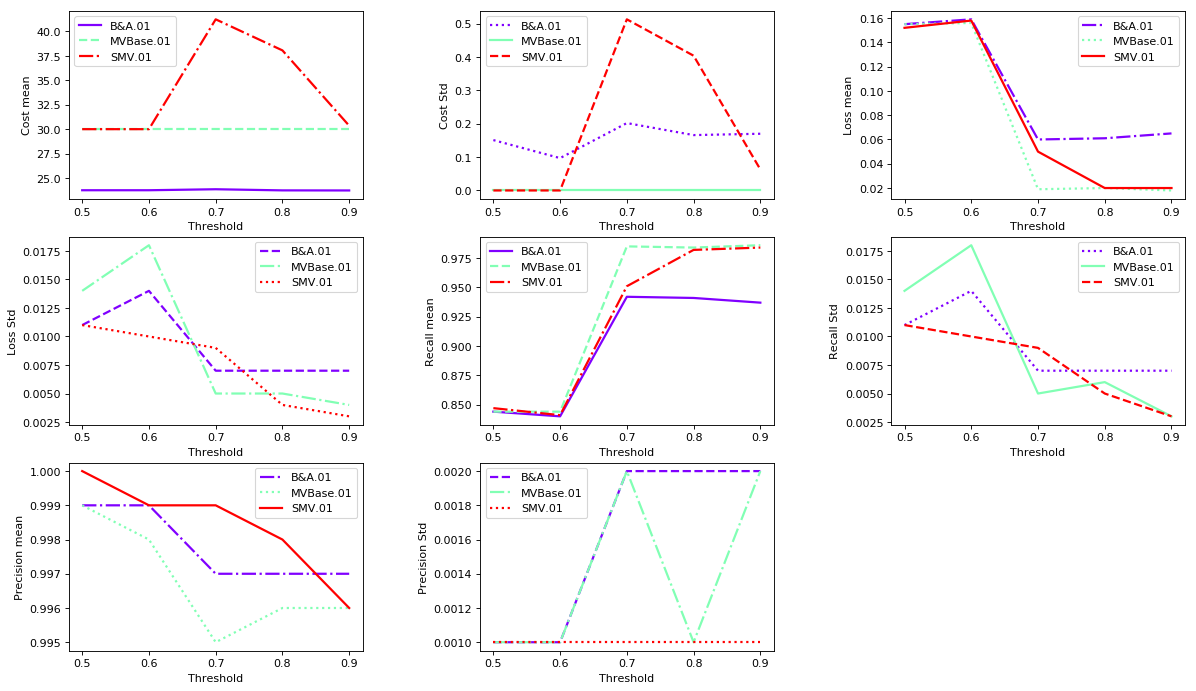

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import random
import itertools
from matplotlib.ticker import NullFormatter 
import warnings
warnings.filterwarnings("ignore")
import math

def plot_results(x, results, xlabel, print_columns):
    colors = cm.rainbow(np.linspace(0, 1, len(results)))
    marker = itertools.cycle((',', '+', '.', 'o', '*')) 
    linestyles = itertools.cycle(('-', '--', '-.', ':'))
    data = {'x': x}
    
    rows = math.ceil(len(print_columns)/3)
    k = int(f'{rows}31')
    plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.tight_layout()
    for column in print_columns:
        ylabel = column
        
        ys = {}
        for d_key, d_val in results.items():
            ys[d_key] = d_val[column]
        
        for y_key, y_val in ys.items():
            data[y_key] = y_val

        df=pd.DataFrame(data)

        i = 0
        for y_key, y_val in ys.items():
            plt.subplot(k)
            plt.plot(data['x'], y_key, data=df, linestyle=next(linestyles), color=colors[i], linewidth=2, label=y_key)
            i += 1

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        
        k += 1
    #end for
    
    plt.gca().yaxis.set_minor_formatter(NullFormatter())
    plt.subplots_adjust(left  = 0.125,  # the left side of the subplots of the figure,
                        right = 0.9,    # the right side of the subplots of the figure,
                        bottom = 0.1,   # the bottom of the subplots of the figure,
                        top = 0.9,      # the top of the subplots of the figure,
                        wspace = 0.4,   # the amount of width reserved for blank space between subplots,
                        hspace = 0.2)
    plt.show()

mv_base_01 = pd.read_csv('./results/it10_d10_b99/baseline_mv_it10_b99_v3_cr01.csv')
ba_01 = pd.read_csv('./results/it10_d10_b99/mv_break_tie_it10_b99_cr01.csv')
mv_01 = pd.read_csv('./results/it10_d10_b99/smart_stop_mv_not_expert_it10_d10_b99_cr01.csv')


print_columns = ["Cost mean","Cost Std", "Loss mean", "Loss Std", "Recall mean", "Recall Std", "Precision mean", "Precision Std"]
cts = [.5,.6,.7,.8,.9]

plot_results(cts,
           {
               "B&A.01": ba_01,
               "MVBase.01": mv_base_01,
               "SMV.01": mv_01,
           }, 
           "Threshold",
            print_columns)    